# LeNet-5: MNIST + PyTorch

- [Automatic Mixed Precision, torch](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html)
- Using Swish activation function, with trainable $\beta$ parameter. Refer to [SWISH: A Self-Gated Activation Function](https://arxiv.org/pdf/1710.05941v1.pdf) paper by Prajit Ramachandran, Barret Zoph and Quoc V. Le.
- Multi-step learning rate scheduler.

In [1]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os, pickle, gc, time
from tqdm import tqdm
from tqdm import trange

In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.0
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 30

In [5]:
# Timing utilities-
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print(f"Total execution time = {end_time - start_time:.3f} sec")
    print(f"Max memory used by tensors = {torch.cuda.max_memory_allocated()} bytes")

In [6]:
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])
     

# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    transform = transforms_apply
)

In [7]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

### LeNet-5 CNN architecture

Refer to PyTorch discussion to train scalar parameters [here](https://discuss.pytorch.org/t/scalar-parameters-not-showing-up-in-model-parameters/121450).

In [8]:
class LeNet5(nn.Module):
    def __init__(self, beta = 1.0):
        super(LeNet5, self).__init__()
        
        # Trainable parameter for swish activation function-
        self.beta = nn.Parameter(torch.tensor(beta, requires_grad = True))
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6, 
            kernel_size = 5, stride = 1,
            padding = 0, bias = False 
        )
        self.bn1 = nn.BatchNorm2d(num_features = 6)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = 16)
        self.fc1 = nn.Linear(
            in_features = 256, out_features = 120,
            bias = True
        )
        self.bn3 = nn.BatchNorm1d(num_features = 120)
        self.fc2 = nn.Linear(
            in_features = 120, out_features = 84,
            bias = True
        )
        self.bn4 = nn.BatchNorm1d(num_features = 84)
        self.fc3 = nn.Linear(
            in_features = 84, out_features = 10,
            bias = True
        )
        
        self.initialize_weights()

        
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def swish_fn(self, x):
        return x * torch.sigmoid(x * self.beta)

    
    def forward(self, x):
        '''
        x = nn.SiLU()(self.pool1(self.bn1(self.conv1(x))))
        x = nn.SiLU()(self.pool1(self.bn2(self.conv2(x))))
        x = x.view(-1, 256)
        x = nn.SiLU()(self.bn3(self.fc1(x)))
        x = nn.SiLU()(self.bn4(self.fc2(x)))
        '''
        x = self.pool(self.bn1(self.conv1(x)))
        x = self.swish_fn(x = x)
        x = self.pool(self.bn2(self.conv2(x)))
        x = self.swish_fn(x = x)
        x = x.view(-1, 256)
        x = self.bn3(self.fc1(x))
        x = self.swish_fn(x = x)
        x = self.bn4(self.fc2(x))
        x = self.swish_fn(x = x)
        x = self.fc3(x)
        return x
    

In [9]:
# Initialize an instance of LeNet-5 CNN architecture-
model = LeNet5(beta = 1.0).to(device)

In [10]:
# Sanity checks for verifying that beta is registered-
for i, param in enumerate(model.parameters()):
    print(f"i: {i}, shape: {param.shape}")

i: 0, shape: torch.Size([])
i: 1, shape: torch.Size([6, 1, 5, 5])
i: 2, shape: torch.Size([6])
i: 3, shape: torch.Size([6])
i: 4, shape: torch.Size([16, 6, 5, 5])
i: 5, shape: torch.Size([16])
i: 6, shape: torch.Size([16])
i: 7, shape: torch.Size([120, 256])
i: 8, shape: torch.Size([120])
i: 9, shape: torch.Size([120])
i: 10, shape: torch.Size([120])
i: 11, shape: torch.Size([84, 120])
i: 12, shape: torch.Size([84])
i: 13, shape: torch.Size([84])
i: 14, shape: torch.Size([84])
i: 15, shape: torch.Size([10, 84])
i: 16, shape: torch.Size([10])


In [11]:
'beta' in model.state_dict().keys()

True

In [12]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"CNN model has {tot_params} parameters")

CNN model has 44857 parameters


In [48]:
# Define cost function-
loss = nn.CrossEntropyLoss().cuda()

[Giving multiple parameters in optimizer](https://discuss.pytorch.org/t/giving-multiple-parameters-in-optimizer/869/5)

In [14]:
# Multiple parameters as input to optimizer-
# params = list(fc1.parameters()) + list(fc2.parameters())
# torch.optim.SGD(params, lr=0.01)

# new_params = list(model.parameters()) + list(model.beta)

# Defing SGD optimizer-
'''
optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.1,
    # params = new_params, lr = 0.1,
    momentum = 0.9, weight_decay = 5e-4
)
'''
optimizer = torch.optim.Adam(
    params = model.parameters(), lr = 0.001,
    betas = (0.9, 0.999), eps = 1e-08,
    weight_decay = 5e-4, amsgrad = False
)

In [ ]:
'''
# Decay lr at 20th, 40th, 60th and 75th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [20, 40, 60, 75],
    gamma = 0.1
)
'''

#### Default Precision

Without ```torch.cuda.amp```, the following simple network executes all ops in default precision (torch.float32):

```
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in range(epochs):
    for input, target in zip(data, targets):
        output = net(input)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        opt.zero_grad() # set_to_none=True here can modestly improve performance
end_timer_and_print("Default precision:")
```

In [15]:
def train_one_epoch(model, train_loader, train_dataset):
    running_loss = 0.0
    running_corrects = 0.0
    
    model.to(device)
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.detach().cpu().item()


def test_one_epoch(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.detach().cpu().item()


#### Adding autocast

Instances of [torch.autocast](https://pytorch.org/docs/stable/amp.html#autocasting) serve as context managers that allow regions of your script to run in mixed precision.

In these regions, CUDA ops run in a dtype chosen by autocast to improve performance while maintaining accuracy. See the [Autocast Op Reference](https://pytorch.org/docs/stable/amp.html#autocast-op-reference) for details on what precision autocast chooses for each op, and under what circumstances.

```
for epoch in range(0): # 0 epochs, this section is for illustration only
    for input, target in zip(data, targets):
        # Runs the forward pass under autocast.
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        # Exits autocast before backward().
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        loss.backward()
        opt.step()
        opt.zero_grad() # set_to_none=True here can modestly improve performance
```

#### Adding GradScaler

[Gradient scaling](https://pytorch.org/docs/stable/amp.html#gradient-scaling) helps prevent gradients with small magnitudes from flushing to zero (“underflowing”) when training with mixed precision.

[torch.cuda.amp.GradScaler](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler) performs the steps of gradient scaling conveniently.

```
# Constructs scaler once, at the beginning of the convergence run, using default args.
# If your network fails to converge with default GradScaler args, please file an issue.
# The same GradScaler instance should be used for the entire convergence run.
# If you perform multiple convergence runs in the same script, each run should use
# a dedicated fresh GradScaler instance.  GradScaler instances are lightweight.
scaler = torch.cuda.amp.GradScaler()

for epoch in range(0): # 0 epochs, this section is for illustration only
    for input, target in zip(data, targets):
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = net(input)
            loss = loss_fn(output, target)

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(opt)

        # Updates the scale for next iteration.
        scaler.update()

        opt.zero_grad() # set_to_none=True here can modestly improve performance
```

#### All together: “Automatic Mixed Precision”

(The following also demonstrates ```enabled```, an optional convenience argument to ```autocast``` and ```GradScaler```. If False, ```autocast``` and ```GradScaler```‘s calls become no-ops. This allows switching between default precision and mixed precision without if/else statements.)

```
use_amp = True

net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

start_timer()
for epoch in range(epochs):
    for input, target in zip(data, targets):
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad() # set_to_none=True here can modestly improve performance
end_timer_and_print("Mixed precision:")
```

#### Inspecting/modifying gradients (e.g., clipping)

All gradients produced by ```scaler.scale(loss).backward()``` are scaled. If you wish to modify or inspect the parameters’ ```.grad``` attributes between ```backward()``` and ```scaler.step(optimizer)```, you should unscale them first using [scaler.unscale_(optimizer)](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler.unscale_).

```
for epoch in range(0): # 0 epochs, this section is for illustration only
    for input, target in zip(data, targets):
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()

        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(opt)

        # Since the gradients of optimizer's assigned params are now unscaled, clips as usual.
        # You may use the same value for max_norm here as you would without gradient scaling.
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.1)

        scaler.step(opt)
        scaler.update()
        opt.zero_grad() # set_to_none=True here can modestly improve performance
```

In [16]:
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled = use_amp)

In [17]:
def train_one_epoch_mixedprecision(model, train_loader, train_dataset):
    running_loss = 0.0
    running_corrects = 0.0
    
    model.to(device)
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            with torch.autocast(
                device_type = 'cuda', dtype = torch.float16,
                enabled = use_amp
            ):
            
                images = images.to(device)
                labels = labels.to(device)

                # Get model predictions-
                outputs = model(images)

                # Compute loss-
                J = loss(outputs, labels)
            
            # Perform backprop-
            scaler.scale(J).backward()
            
            # Update parameters-
            scaler.step(optimizer = optimizer)
            scaler.update()
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Compute model's performance statistics-
            # running_loss += J.item() * images.size(0)
            running_loss += scaler.scale(J).item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.detach().cpu().item()


def test_one_epoch_mixedprecision(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                with torch.autocast(
                device_type = 'cuda', dtype = torch.float16,
                enabled = use_amp
            ):
                
                    images = images.to(device)
                    labels = labels.to(device)

                    # Predict using trained model-
                    outputs = model(images)
                    _, y_pred = torch.max(outputs, 1)

                    # Compute validation loss-
                    J_val = loss(outputs, labels)
                
                scaler.scale(J_val)
                # running_loss_val += J_val.item() * labels.size(0)
                running_loss_val += scaler.scale(J_val).item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.detach().cpu().item()


In [19]:

start_timer()
train_loss, train_acc = train_one_epoch_mixedprecision(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
end_timer_and_print("Mixed precision:")

start_timer()
train_loss, train_acc = train_one_epoch(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
end_timer_and_print("Default precision:")


Training: : 100%|████████████████████████████████████| 235/235 [00:11<00:00, 19.63batch/s, accuracy=98.7, loss=3.03e+3]



Mixed precision:
Total execution time = 11.975 sec
Max memory used by tensors = 28192256 bytes


Training: : 100%|█████████████████████████████████████| 235/235 [00:12<00:00, 19.31batch/s, accuracy=99.1, loss=0.0352]


Default precision:
Total execution time = 12.175 sec
Max memory used by tensors = 34360320 bytes


In [20]:
start_timer()
test_loss, test_acc = test_one_epoch_mixedprecision(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
end_timer_and_print("Mixed precision:")

start_timer()
test_loss, test_acc = test_one_epoch(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
end_timer_and_print("Default precision:")


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 22.03batch/s, val_acc=98.8, val_loss=2.66e+3]



Mixed precision:
Total execution time = 1.819 sec
Max memory used by tensors = 22577152 bytes


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 23.13batch/s, val_acc=98.8, val_loss=0.0405]


Default precision:
Total execution time = 1.729 sec
Max memory used by tensors = 25678848 bytes


In [21]:
# Python3 dict to contain training metrics-
train_history = {}

# Variable to store 'best' model-
best_val_acc = 0

In [22]:
# start_timer()

for epoch in range(1, num_epochs + 1):
    
    start_timer()
    # One epoch of training-
    train_loss, train_acc = train_one_epoch_mixedprecision(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    # end_timer_and_print("Mixed precision:")
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_one_epoch_mixedprecision(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    current_lr = optimizer.param_groups[0]["lr"]
    # scheduler.step()

    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}%,"
          f" beta = {model.beta.cpu().detach().numpy():.6f} & LR = {current_lr:.5f}"
         )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr, 'beta': model.beta.cpu().detach().numpy()
    }
    
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        torch.save(model.state_dict(), "LeNet5_MNIST_amp_best_acc.pth")


Validation: : 100%|█████████████████████████████████| 40/40 [00:02<00:00, 18.82batch/s, val_acc=98.8, val_loss=2.36e+3]


Epoch: 1; loss = 1886.9572, acc = 99.18%  val loss = 2362.8918, val acc = 98.82%, beta = 1.559879 & LR = 0.00100
Saving model with highest val_acc = 98.82%



Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 20.49batch/s, val_acc=98.8, val_loss=2.73e+3]


Epoch: 2; loss = 1593.0909, acc = 99.34%  val loss = 2731.6328, val acc = 98.76%, beta = 1.648291 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:02<00:00, 18.88batch/s, val_acc=98.8, val_loss=2.46e+3]


Epoch: 3; loss = 1350.2170, acc = 99.46%  val loss = 2462.5070, val acc = 98.78%, beta = 1.735514 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 22.77batch/s, val_acc=98.9, val_loss=2.48e+3]


Epoch: 4; loss = 1252.8159, acc = 99.50%  val loss = 2481.8336, val acc = 98.85%, beta = 1.822876 & LR = 0.00100
Saving model with highest val_acc = 98.85%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.07batch/s, val_acc=99, val_loss=2.08e+3]


Epoch: 5; loss = 1172.9846, acc = 99.51%  val loss = 2081.8763, val acc = 98.99%, beta = 1.917096 & LR = 0.00100
Saving model with highest val_acc = 98.99%



Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 20.92batch/s, val_acc=98.7, val_loss=3.01e+3]


Epoch: 6; loss = 1041.3140, acc = 99.58%  val loss = 3012.1032, val acc = 98.65%, beta = 1.999009 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 20.48batch/s, val_acc=98.7, val_loss=5.19e+3]


Epoch: 7; loss = 1583.6457, acc = 99.59%  val loss = 5186.1458, val acc = 98.66%, beta = 2.091959 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:02<00:00, 18.28batch/s, val_acc=98.9, val_loss=4.37e+3]


Epoch: 8; loss = 1975.1314, acc = 99.61%  val loss = 4367.7401, val acc = 98.94%, beta = 2.177973 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:02<00:00, 19.56batch/s, val_acc=98.9, val_loss=4.62e+3]


Epoch: 9; loss = 1884.8895, acc = 99.65%  val loss = 4623.7161, val acc = 98.92%, beta = 2.262912 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.58batch/s, val_acc=98.9, val_loss=4.8e+3]


Epoch: 10; loss = 1755.5616, acc = 99.69%  val loss = 4800.1152, val acc = 98.87%, beta = 2.344560 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:02<00:00, 18.25batch/s, val_acc=98.9, val_loss=4.66e+3]


Epoch: 11; loss = 1798.4288, acc = 99.69%  val loss = 4663.4645, val acc = 98.86%, beta = 2.425687 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 22.90batch/s, val_acc=98.9, val_loss=5.09e+3]


Epoch: 12; loss = 1585.8878, acc = 99.73%  val loss = 5092.6363, val acc = 98.91%, beta = 2.502721 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 23.26batch/s, val_acc=99, val_loss=4.31e+3]


Epoch: 13; loss = 1610.0857, acc = 99.72%  val loss = 4312.9143, val acc = 98.99%, beta = 2.572848 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 20.70batch/s, val_acc=98.9, val_loss=4.69e+3]


Epoch: 14; loss = 1546.4952, acc = 99.71%  val loss = 4692.5548, val acc = 98.94%, beta = 2.645633 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 23.23batch/s, val_acc=99, val_loss=4.67e+3]


Epoch: 15; loss = 1471.6643, acc = 99.74%  val loss = 4665.5862, val acc = 98.96%, beta = 2.713258 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:02<00:00, 19.42batch/s, val_acc=98.8, val_loss=1.06e+4]


Epoch: 16; loss = 2844.6015, acc = 99.76%  val loss = 10612.9001, val acc = 98.79%, beta = 2.765795 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 23.07batch/s, val_acc=99, val_loss=8.44e+3]


Epoch: 17; loss = 3083.7432, acc = 99.75%  val loss = 8441.5064, val acc = 99.04%, beta = 2.827121 & LR = 0.00100
Saving model with highest val_acc = 99.04%



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 23.38batch/s, val_acc=99, val_loss=8.9e+3]


Epoch: 18; loss = 2992.7430, acc = 99.73%  val loss = 8899.0164, val acc = 98.98%, beta = 2.883867 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 23.35batch/s, val_acc=98.9, val_loss=9.57e+3]


Epoch: 19; loss = 2625.2585, acc = 99.81%  val loss = 9573.8323, val acc = 98.89%, beta = 2.916879 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 23.32batch/s, val_acc=98.8, val_loss=1.08e+4]


Epoch: 20; loss = 2647.8978, acc = 99.77%  val loss = 10825.1696, val acc = 98.75%, beta = 2.962232 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 23.19batch/s, val_acc=98.9, val_loss=9.34e+3]


Epoch: 21; loss = 3076.3189, acc = 99.75%  val loss = 9342.5474, val acc = 98.91%, beta = 3.008791 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 23.34batch/s, val_acc=99, val_loss=9.05e+3]


Epoch: 22; loss = 2605.1812, acc = 99.78%  val loss = 9045.0178, val acc = 98.96%, beta = 3.036449 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 22.93batch/s, val_acc=99, val_loss=9.28e+3]


Epoch: 23; loss = 2978.7491, acc = 99.75%  val loss = 9281.9256, val acc = 99.02%, beta = 3.068920 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 23.17batch/s, val_acc=99.1, val_loss=1.48e+4]


Epoch: 24; loss = 3681.4911, acc = 99.82%  val loss = 14820.4561, val acc = 99.14%, beta = 3.079891 & LR = 0.00100
Saving model with highest val_acc = 99.14%



Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 20.49batch/s, val_acc=99.1, val_loss=1.62e+4]


Epoch: 25; loss = 5091.4441, acc = 99.81%  val loss = 16206.1089, val acc = 99.05%, beta = 3.093501 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 23.01batch/s, val_acc=98.9, val_loss=1.86e+4]


Epoch: 26; loss = 5209.1770, acc = 99.79%  val loss = 18611.0497, val acc = 98.90%, beta = 3.117620 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 23.10batch/s, val_acc=99.1, val_loss=1.84e+4]


Epoch: 27; loss = 5948.8394, acc = 99.73%  val loss = 18415.4134, val acc = 99.05%, beta = 3.154265 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 23.20batch/s, val_acc=99, val_loss=1.83e+4]


Epoch: 28; loss = 4716.6755, acc = 99.82%  val loss = 18277.9032, val acc = 98.97%, beta = 3.168463 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 20.38batch/s, val_acc=99.1, val_loss=1.66e+4]


Epoch: 29; loss = 4718.5647, acc = 99.80%  val loss = 16613.4000, val acc = 99.09%, beta = 3.168017 & LR = 0.00100


Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 21.93batch/s, val_acc=98.9, val_loss=1.99e+4]

Epoch: 30; loss = 4712.6257, acc = 99.82%  val loss = 19900.1971, val acc = 98.90%, beta = 3.178592 & LR = 0.00100


In [20]:
# Save training metrics as pickled object-
with open("LeNet5_MNIST_swish_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

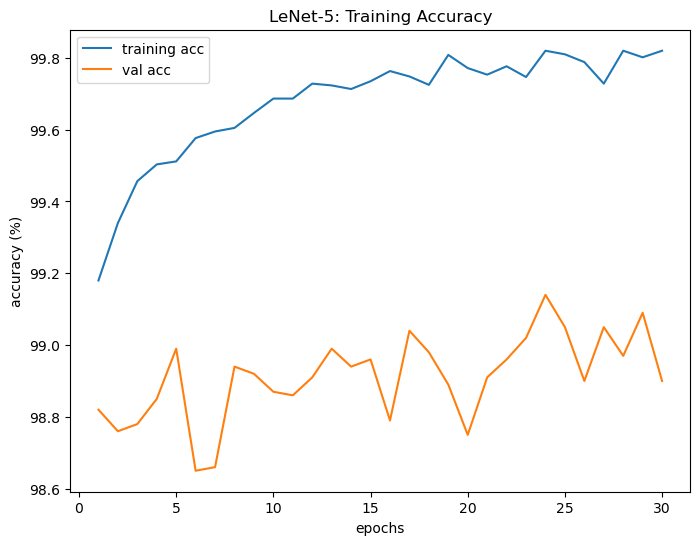

In [23]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['train_acc'] for k in train_history.keys()], label = 'training acc')
plt.plot(list(train_history.keys()), [train_history[k]['val_acc'] for k in train_history.keys()], label = 'val acc')
plt.title("LeNet-5: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

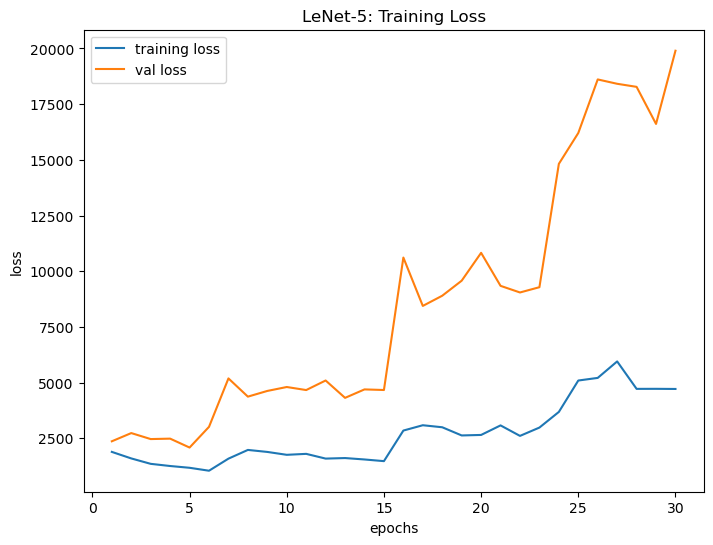

In [24]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['train_loss'] for k in train_history.keys()], label = 'training loss')
plt.plot(list(train_history.keys()), [train_history[k]['val_loss'] for k in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("LeNet-5: Training Loss")
plt.show()

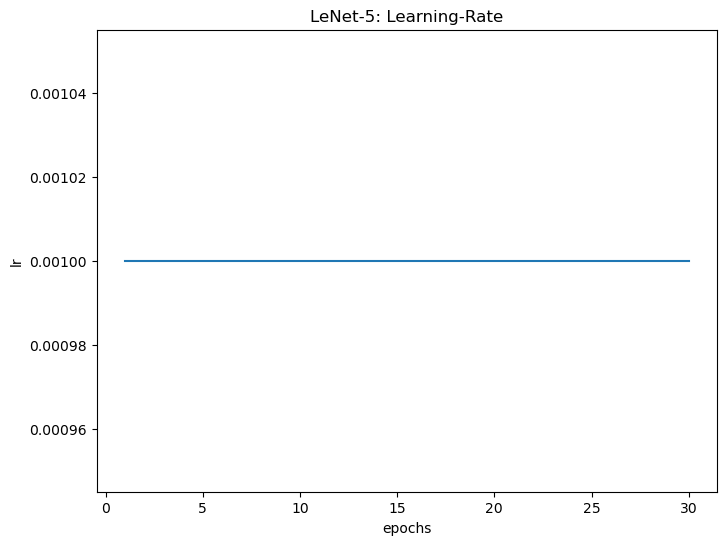

In [25]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['lr'] for k in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LeNet-5: Learning-Rate")
plt.show()

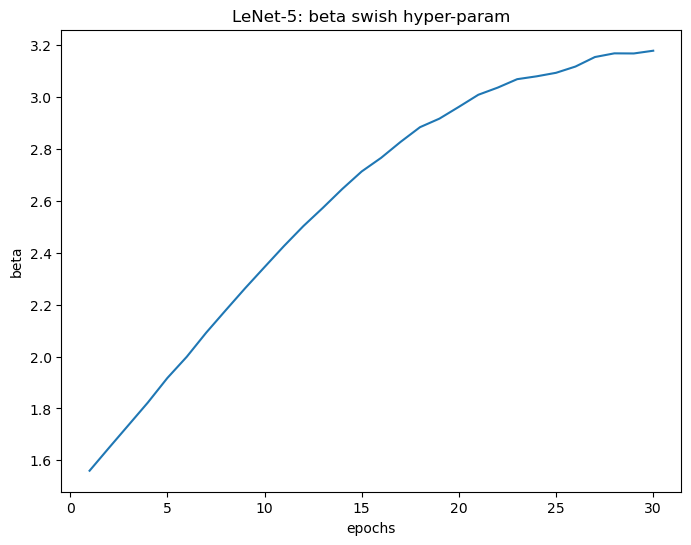

In [26]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['beta'] for k in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("beta")
plt.title("LeNet-5: beta swish hyper-param")
plt.show()

#### Saving/Resuming

To save/resume Amp-enabled runs with bitwise accuracy, use [scaler.state_dict](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler.state_dict) and [scaler.load_state_dict](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler.load_state_dict).

When saving, save the scaler state dict alongside the usual model and optimizer state dicts. Do this either at the beginning of an iteration before any forward passes, or at the end of an iteration after ```scaler.update()```.

```
checkpoint = {"model": net.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
# Write checkpoint as desired, e.g.,
# torch.save(checkpoint, "filename")
```

In [27]:
# Create checkpoint-
chkpt = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scaler': scaler.state_dict()
}

# Save checkpoint-
torch.save(chkpt, 'LeNet5_swish_amp.pth')

In [28]:
del model

When resuming, load the scaler state dict alongside the model and optimizer state dicts.

```
# Read checkpoint as desired, e.g.,
# dev = torch.cuda.current_device()
# checkpoint = torch.load("filename",
#                         map_location = lambda storage, loc: storage.cuda(dev))
net.load_state_dict(checkpoint["model"])
opt.load_state_dict(checkpoint["optimizer"])
scaler.load_state_dict(checkpoint["scaler"])
```

If a checkpoint was created from a run without Amp, and you want to resume training with Amp, load model and optimizer states from the checkpoint as usual. The checkpoint won’t contain a saved scaler state, so use a fresh instance of ```GradScaler```.

If a checkpoint was created from a run with Amp and you want to resume training without Amp, load model and optimizer states from the checkpoint as usual, and ignore the saved scaler state.


#### Inference/Evaluation

```autocast``` may be used by itself to wrap inference or evaluation forward passes. ```GradScaler``` is not necessary.


#### Advanced topics

See the [Automatic Mixed Precision Examples](https://pytorch.org/docs/stable/notes/amp_examples.html) for advanced use cases including:

- Gradient accumulation

- Gradient penalty/double backward

- Networks with multiple models, optimizers, or losses

- Multiple GPUs (```torch.nn.DataParallel``` or ```torch.nn.parallel.DistributedDataParallel```)

- Custom autograd functions (subclasses of ```torch.autograd.Function```)

If you perform multiple convergence runs in the same script, each run should use a dedicated fresh GradScaler instance. GradScaler instances are lightweight.

If you’re registering a custom C++ op with the dispatcher, see the [autocast section](https://pytorch.org/tutorials/advanced/dispatcher.html#autocast) of the dispatcher tutorial.

In [31]:
checkpoint = torch.load("LeNet5_swish_amp.pth", map_location = lambda storage, loc: storage.cuda(device))

# Load best trained parameters from before-
best_model = LeNet5().to(device)
best_model.load_state_dict(checkpoint["model"])
# best_model.load_state_dict(torch.load("LeNet5_MNIST_best_val_acc.pth"))

<All keys matched successfully>

In [32]:
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled = use_amp)

opt = torch.optim.Adam(
    params = best_model.parameters(), lr = 0.001,
    betas = (0.9, 0.999), eps = 1e-08,
    weight_decay = 5e-4, amsgrad = False
)

In [33]:
opt.load_state_dict(checkpoint["optimizer"])
scaler.load_state_dict(checkpoint["scaler"])

In [49]:
start_timer()
# Get validation metrics after 1 epoch of training-
val_loss, val_acc = test_one_epoch_mixedprecision(
    model = best_model, test_loader = test_loader,
    test_dataset = test_dataset
)
end_timer_and_print("Mixed precision: ")

Validation: : 100%|█████████████████████████████████| 40/40 [00:01<00:00, 23.25batch/s, val_acc=98.9, val_loss=1.99e+4]


Mixed precision: 
Total execution time = 1.724 sec
Max memory used by tensors = 24344064 bytes


In [50]:
start_timer()
# Get validation metrics after 1 epoch of training-
val_loss_noamp, val_acc_noamp = test_one_epoch(
    model = best_model, test_loader = test_loader,
    test_dataset = test_dataset
)
end_timer_and_print("Fixed precision: ")

Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 22.81batch/s, val_acc=98.9, val_loss=0.038]


Fixed precision: 
Total execution time = 1.753 sec
Max memory used by tensors = 27445760 bytes


In [51]:
print("LeNet-5 'best' trained validation metrics: ",
      f"loss: {val_loss:.4f} & accuracy = {val_acc:.2f}%"
     )

LeNet-5 'best' trained validation metrics:  loss: 19900.1971 & accuracy = 98.90%


In [43]:
# max([train_history[k]['val_acc'] for k in train_history.keys()])
max_val_acc = 0
max_epoch = 0

for e in train_history.keys():
    if train_history[e]['val_acc'] > max_val_acc:
        max_val_acc = train_history[e]['val_acc']
        max_epoch = e

In [44]:
max_epoch, max_val_acc

(24, 99.13999938964844)

In [46]:
print(f"highest val acc = {train_history[max_epoch]['val_acc']:.2f}%",
      f" is obtained for beta = {train_history[max_epoch]['beta']:.4f}"
)

highest val acc = 99.14%  is obtained for beta = 3.0799
